# <span style="color:#F72585"><center>Caso aplicado de HDBSCAN: Prueba saber 11, Bogotá. D.C</center></span>

<figure>
<center>
<img src="Images/icfes.png", align="center" /> 
</center>   
</figure>
Fuente: <a href="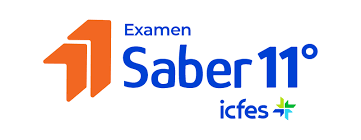">, via ICFES.gov

**Objetivo**: Realizar una caracterización de los estudiantes que presentaron la prueba saber 11 calendario A, año 2021. Se tomó como subconjunto todos aquellos estudiantes que tenían como residencia Bogotá.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import hdbscan 
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
# Importamos las librerías para reducir y visualizar
import os, umap
import umap.plot
import gdown
%matplotlib inline

sns.set_theme()
sns.set_color_codes()
plot_kwds = {'alpha' : 0.35, 's' : 40, 'linewidths':0}

## <span style="color:#4361EE">Puesta en marcha: Caso aplicado: Prueba Saber 11</span>

### <span style="color:#4CC9F0">Lectura de los datos</span>

A continuación procedemos a cambiar de directorio para así proceder a descargar los datos de Google Drive

In [2]:
os.chdir('./Data')

In [3]:
url = "https://drive.google.com/file/d/1oEQCxqRX-OMzVw-tYJ6a4G30zHmMj3XC/view?usp=share_link"
output = "saber11a.txt"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1oEQCxqRX-OMzVw-tYJ6a4G30zHmMj3XC
To: /home/el_rancio_dave/Documents/HDBSCAN-y-GMM/Data/saber11a.txt
100%|██████████| 403M/403M [02:13<00:00, 3.02MB/s] 


'saber11a.txt'

Como ya se había mencionado lo datos fueron obtenidos de la pagina oficial del [ICFES](https://www.icfes.gov.co/data-icfes) alli usted podra obtener la base de datos y realizando el filtro pertinente por ciudad o departamento podrá reproducir los resultados presentados en el presente notebook.

In [4]:
df = pd.read_csv("./saber11a.txt", sep = "|")

Se realiza el filtro por Bogotá, quien será la población objetivo del estudio. 

In [5]:
# Filtramos por Bogotá
df = df[df["ESTU_DEPTO_RESIDE"] == "BOGOTÁ"]
df.shape

(78951, 82)

Ahora procedemos a retirar las variables categóricas las cuales no se tendrán en cuenta a lo largo del estudio ya que aparentan no aportar mucho a este. 

Dado que el objetivo principal está en caracterizar a la población por las variables demográficas, también se retiraran las variables correspondientes a los valores de los puntajes obtenidos en cada componente evaluada en la prueba saber 11.  


In [6]:
# Quitamos las variables que no parecieron pertinentes
# Se quitan las variables numéricas puesto que sólo se considerarán las categóricas sociodemográficas
df.drop(columns = ["ESTU_TIPODOCUMENTO", "PERIODO","ESTU_CONSECUTIVO", "ESTU_NACIONALIDAD", # quito la variable nacionalidad. Dejo el departamento y el NSE de la institución
                   "ESTU_ESTUDIANTE","ESTU_PAIS_RESIDE",'ESTU_TIENEETNIA' ,'ESTU_COD_RESIDE_DEPTO', 'ESTU_MCPIO_RESIDE',
       'ESTU_COD_RESIDE_MCPIO','COLE_CODIGO_ICFES',
       'COLE_COD_DANE_ESTABLECIMIENTO', 'COLE_NOMBRE_ESTABLECIMIENTO','COLE_COD_DANE_SEDE', 'COLE_NOMBRE_SEDE','COLE_COD_MCPIO_UBICACION', 'COLE_MCPIO_UBICACION',
       'COLE_COD_DEPTO_UBICACION', 'COLE_DEPTO_UBICACION',
       'ESTU_PRIVADO_LIBERTAD', 'ESTU_COD_MCPIO_PRESENTACION', "COLE_BILINGUE", "COLE_CARACTER",
       'ESTU_MCPIO_PRESENTACION',
       'ESTU_COD_DEPTO_PRESENTACION','PERCENTIL_ESPECIAL_GLOBAL','ESTU_ESTADOINVESTIGACION',
       'ESTU_TIPOREMUNERACION','ESTU_HORASSEMANATRABAJA','COLE_CALENDARIO',
       'ESTU_DEPTO_PRESENTACION',  'PERCENTIL_LECTURA_CRITICA', 'DESEMP_LECTURA_CRITICA',
       'PERCENTIL_MATEMATICAS', 'DESEMP_MATEMATICAS',
       'PERCENTIL_C_NATURALES', 'DESEMP_C_NATURALES','PERCENTIL_SOCIALES_CIUDADANAS',
       'DESEMP_SOCIALES_CIUDADANAS','PERCENTIL_INGLES',
       'DESEMP_INGLES','PERCENTIL_GLOBAL',
       'PERCENTIL_ESPECIAL_GLOBAL',
       'PUNT_LECTURA_CRITICA', 'PUNT_MATEMATICAS', 'PUNT_C_NATURALES',
       'PUNT_SOCIALES_CIUDADANAS', 'PUNT_INGLES', 'PUNT_GLOBAL',
       'ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_INDIVIDUAL',
       'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_FECHANACIMIENTO','ESTU_DEPTO_RESIDE' # estoy quitando el departamento porque curiosamente CAUCA se lleva buena parte...
       ], inplace = True)
# Podría intentar los departamentos... DEJO LOS DEPARTAMENTOS A VER
df.dropna(inplace = True)

In [7]:
categoricas = df.select_dtypes(include=["object"])

In [8]:
categoricas.shape # 29 variables categóricas

(69931, 29)

### <span style="color:#4CC9F0">One-hot Encoder</span>

Ahora se procede a codificar las variables categóricas empleando la codificación one-hot encoder.

In [9]:
# Convertimos las variables categóricas a one-hot
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
datos = np.zeros((categoricas.shape[0],1))  
for i in range(categoricas.shape[1]):
  variable = df.iloc[:,i]
  values = array(variable)
  # integer encode
  integer_encoded = label_encoder.fit_transform(values)
  # binary encode
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  variable = onehot_encoder.fit_transform(integer_encoded)
  datos = np.concatenate((datos,variable),axis = 1)

In [10]:
# Se elimina la primera columna puesto que fue llenada de 0's
datos = datos[:,1:]

In [11]:
datos.shape # 130 dimensiones iniciales

(69931, 134)

Una vez las variables categóricas han sido codificadas por medio de one-hot encoder se procede a realizar una reducción de la dimensionalidad empleando el algoritmo de ACP o análisis de componentes principales.

### <span style="color:#4CC9F0">Reducción de dimensión</span>

Para elegir el número de componentes, se estableció dejar aquellos componentes que retuvieran por lo menos el 90% de la varianza, resultando de ahí 60 componentes

In [12]:
pca = PCA(n_components=60, whiten = True, svd_solver = "full") 
cate = pca.fit_transform(datos) 

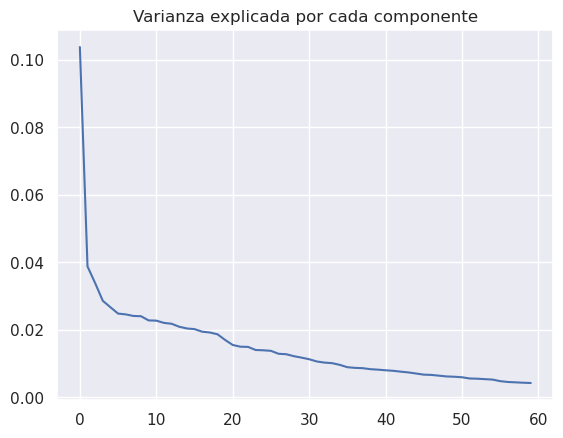

In [14]:
x = range(len(pca.explained_variance_))
plt.plot(x,pca.explained_variance_ratio_)
plt.title("Varianza explicada por cada componente");

In [15]:
print("Con",len(pca.explained_variance_[:60]),"componentes,","la varianza explicada es del",pca.explained_variance_ratio_[:60].sum()*100,"%") # random_seed. Tenerlo presente

Con 60 componentes, la varianza explicada es del 90.89071897801085 %


### <span style="color:#4CC9F0">UMAP (Uniform Manifold Approximation and Projection)</span>

Ahora, se procede a aplicar una técnica de reducción de dimensionalidad mejor conocida por sus siglas en inglés como UMAP. El objetivo para este caso práctico no está en la reducción de dimensionalidad sino en encontrar una reorganización de espacio de los datos con el fin de poder encontrar información escondida dentro de este.

In [ ]:
# Instanciamos
mapperumap = umap.UMAP(n_neighbors = 10, random_state = 123,n_components = 60, learning_rate = 0.5)  
transformadosumap = mapperumap.fit_transform(cate) # obtenemos las 60 coordenadas

### <span style="color:#4CC9F0">HDBSCAN (Hierarchical Density-based Spatial Clustering of Applications with Noise)</span>

Ya una vez se transformaron las variables, se procede a realizar el análisis de conglomerados por medio del algoritmo HHDBSCAN. Se tomó como tamaño mínimo del cluster en 300

In [ ]:
# Ya teniendo las 60 dimensiones, procedemos a realizar el hdbscan
np.random.seed(123)
clusterer = hdbscan.HDBSCAN(metric = "euclidean",min_cluster_size = 300)
clusterer.fit(transformadosumap)

HDBSCAN(min_cluster_size=300)

In [ ]:
# Se ven cuántas etiquetas y cuántas personas estan asociadas a cada una de ellas
dflabels = pd.DataFrame(clusterer.labels_)
dflabels.value_counts()

 5    48500
 3     5144
 2     4735
 1     3714
 0     3706
 4     3490
-1      642
dtype: int64

Ya una vez se tienen los clusters, se procede a realizar una reducción de los datos a 2 y 3 dimensiones, con el fin de poder apreciar su estructura*.
* **Nota:** Esta reducción se realiza solo con efectos de visualización de los datos 

In [ ]:
np.random.seed(1234)
mapper = umap.UMAP(random_state=123).fit(cate)

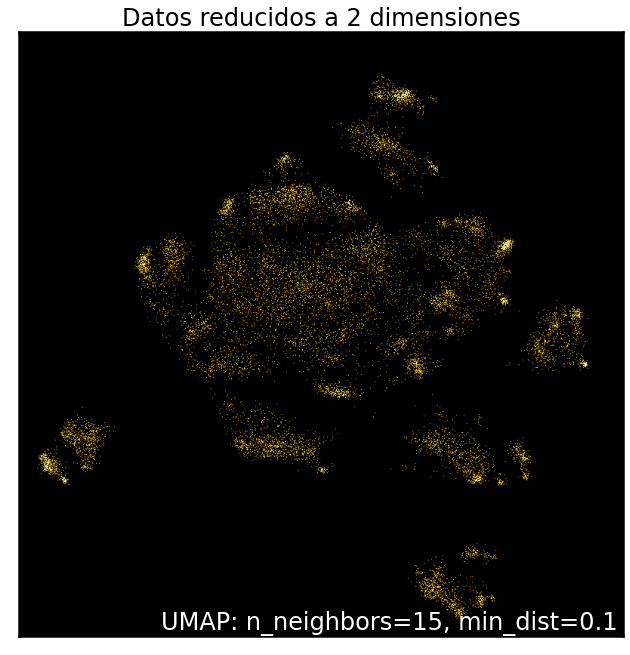

In [ ]:
umap.plot.points(mapper, theme = "fire")
plt.title("Datos reducidos a 2 dimensiones");

Continuando con el objetivo de la visualización, se realiza el mismo gráfico en dos dimensiones, pero coloreando de acuerdo al cluster asignado a cada punto por el algoritmo HDBSCAN. Los puntos morados corresponden a observaciones que no se pudieron clasificar en ningún grupo.

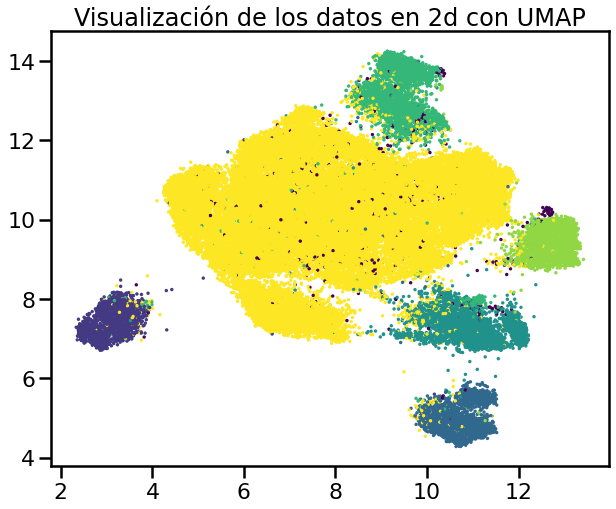

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(visua[:,0],visua[:,1], s = 2, c = clusterer.labels_)
plt.title("Visualización de los datos en 2d con UMAP");

Por último, se procede a realizar un gráfico en 3 dimensiones con el fin de tener una perspectiva mas amplia de como se distribuyen los datos en el espacio.

In [ ]:
# visualizaciones
visua3d = umap.UMAP(random_state=123, n_components = 3).fit_transform(cate)

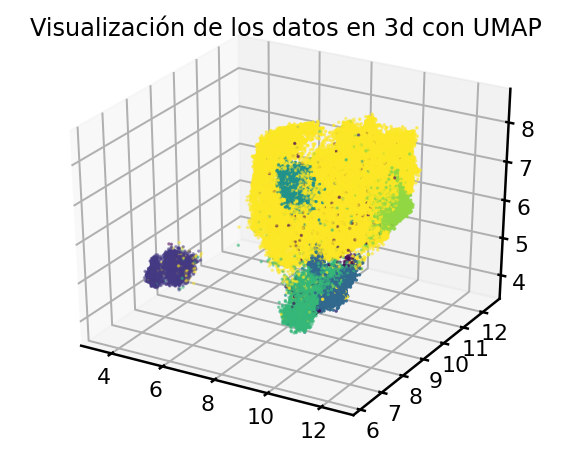

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(visua3d[:,0],visua3d[:,1],visua3d[:,2], s = 2, c = clusterer.labels_)
ax.set_title("Visualización de los datos en 3d con UMAP");

### <span style="color:#4CC9F0">Guardado de las etiquetas</span>

Con el fin de agilizar el procesamiento de cómputo y ahorrar tiempo se procede a almacenar tanto los datos “transformados” por UMAP como las etiquetas encontradas por HDBSCAN.

In [ ]:
df["etiqueta"] = clusterer.labels_

In [ ]:
## Obtengo las etiquetas porque las voy a necesitar
df["etiqueta"].to_csv("etiquetasumapfinal.csv")

In [ ]:
transformadosumapdf = pd.DataFrame(transformadosumap)
transformadosumapdf.to_csv("coordenadasumapfinal.csv")